In [1]:
# load the rpy2 extension
%load_ext rpy2.ipython

### Enter contention criteria below or leave blank

In [2]:
%matplotlib inline
from IPython.html import widgets
from IPython.display import display
ta = widgets.Textarea(
    description='Contention Criteria:',
    value='',
)
display(ta)
#  RO.ORIG_CMPLN_DESC LIKE '%%NOIS%%'
#  RO.ORIG_CAUS_DESC LIKE '%%NOIS%%'
#  RO.ORIG_CRRT_DESC LIKE '%%NOIS%%'

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Enter year, model, factory, destination, and replaced part #:

In [18]:
import pyodbc                # Needed to connect to ODBC data sources
import crypto, codecs
import numpy as np
import pandas as pd
from datetime import datetime
pd.set_option("display.max_rows",1000)
76600
# Get the necessary input from the user
year      = input("Enter model year(s) separated by comma: ")
factory   = input("Enter factory code(s) separated by comma: ").upper()
model     = input("Enter model name(s) separated by comma: ").upper()
dest_code = input("Enter destination code(s) separated by comma: ").upper()
part      = input("Enter part number(s) separated by comma: ")

Enter model year(s) separated by comma: 2012,2013,2014,2015
Enter factory code(s) separated by comma: hcm,hma
Enter model name(s) separated by comma: mdx
Enter destination code(s) separated by comma: ka,kl
Enter part number(s) separated by comma: 76600,76610


### Execute all cells below:

In [19]:
key = codecs.escape_decode(open(r'D:\webapps\_server\pyodbc\key', 'r').read())[0]
pw_file = open(r'D:\webapps\_server\pyodbc\cmq.txt', 'r')
pwd = pw_file.read()
pw = crypto.decrypt_with_key(key, pwd)
userid = 'rb10'
pw_file.close()

cnxn_string = 'DSN=CMQ_PROD;UID=' + userid + ';PWD=' + pw

cnxn = pyodbc.connect(cnxn_string)
cursor = cnxn.cursor()

start = datetime.now()

# Make a list for each parameter input
years      = year.split(',')
factories  = factory.split(',')
models     = model.split(',')
dest_codes = dest_code.split(',')
parts      = part.split(',')

# Now get the number of items in each list so that we can properly use the .join() function below
Y = len(years)       # The number of years the user entered
F = len(factories)   # The number of factories the user entered
M = len(models)      # The number of models the user entered
D = len(dest_codes)  # The number of destination codes the user entered
P = len(parts)       # The number of part numbers the user entered

sql1 = """
WITH VEHICLES as (
SELECT
PROD.VIN_SK,
RTL_DLR.STATE_CD

FROM CMQ.V_FACT_VHCL_PRDN_SLS prod

INNER JOIN CMQ.V_DIM_MTO MTO
ON PROD.MTO_SK = MTO.MTO_SK

INNER JOIN CMQ.V_DIM_DLR RTL_DLR
ON PROD.RTL_DLR_SK = RTL_DLR.DLR_SK

WHERE
MTO.MDL_YR IN(%s)
AND MTO.FCTRY_CD IN(%s)
AND MTO.MDL_NM IN(%s)
AND MTO.DEST_CD IN(%s)
),

CLAIMS AS (
SELECT
CLAIMS.CLM_SK,
CLAIMS.VIN_SK,
CLM_DLR.STATE_CD

FROM CMQ.V_FACT_CLM_TRX CLAIMS

INNER JOIN CMQ.V_DIM_CLM CLAIM_DETAILS
ON CLAIMS.CLM_SK = CLAIM_DETAILS.CLM_SK

INNER JOIN CMQ.V_DIM_MTO MTO
ON CLAIMS.MTO_SK = MTO.MTO_SK

INNER JOIN CMQ.V_DIM_PART FAIL_PART
ON CLAIMS.FAIL_PART_SK = FAIL_PART.PART_SK

INNER JOIN CMQ.V_DIM_SUBL_CD SUBLET1
ON CLAIMS.SUBL_01_SK = SUBLET1.SUBL_CD_SK

INNER JOIN CMQ.V_DIM_SUBL_CD SUBLET2
ON CLAIMS.SUBL_02_SK = SUBLET2.SUBL_CD_SK

INNER JOIN CMQ.V_DIM_DLR CLM_DLR
ON CLAIMS.SVC_DLR_SK = CLM_DLR.DLR_SK

INNER JOIN CMQ.V_DIM_RO RO
ON CLAIMS.RO_SK = RO.RO_SK

WHERE
MTO.MDL_YR IN(%s)
AND MTO.FCTRY_CD IN(%s)
AND MTO.MDL_NM IN(%s)
AND MTO.DEST_CD IN(%s)
AND CLAIMS.CAMP_SK <= 0
AND NOT LEFT(CLAIM_DETAILS.CLM_NO,1) IN ('T', 'R')
AND NOT LEFT(FAIL_PART.PART_NO,2) = '08'
AND NOT FAIL_PART.SHRT_PART_NO IN ('TCHV','TCAV')
AND NOT SUBLET1.SUBL_CD = 'GW'
AND NOT SUBLET2.SUBL_CD = 'GW'
"""

sql2 = ta.value

sql3 = """
),

REPLACED as (
SELECT
REPLPART.CLM_SK

FROM CMQ.V_FACT_CLM_REPL_PART REPLPART

INNER JOIN CLAIMS CLAIMS
ON REPLPART.CLM_SK = CLAIMS.CLM_SK

INNER JOIN CMQ.V_DIM_PART PART
ON PART.PART_SK = REPLPART.REPL_PART_SK

WHERE
PART.SHRT_PART_NO IN(%s)
AND REPLPART.REPL_PART_QTY > 0
AND REPLPART.ADJ_PART_QTY > 0
AND REPLPART.VHCL_DEST_CD IN(%s)
),

claims_unique as (
SELECT
MIN(REPLACED.CLM_SK) as CLM_SK,
CLAIMS.VIN_SK,
CLAIMS.STATE_CD

FROM claims claims

INNER JOIN REPLACED REPLACED ON
CLAIMS.CLM_SK = REPLACED.CLM_SK

GROUP BY
CLAIMS.VIN_SK,
CLAIMS.STATE_CD
)

SELECT
MDL_YR,
FCTRY_CD,
MDL_NM,
AF_MTH,
RO_MTH,
STATE_CD,
SUM(SALE_QTY) AS SALE_QTY,
SUM(VEH_QTY) AS VEH_QTY,
SUM(CLAIM_QTY) AS CLAIM_QTY,
SUM(CLAIM_AMT) AS CLAIM_AMT

FROM (
    SELECT
    MDL_YR,
    FCTRY_CD,
    MDL_NM,
    AF_MTH,
    RO_MTH,
    STATE_CD,
    SUM(SALE_QTY) AS SALE_QTY,
    SUM(VEH_QTY) AS VEH_QTY,
    SUM(CLAIM_QTY) AS CLAIM_QTY,
    SUM(CLAIM_AMT) AS CLAIM_AMT

    FROM (
        SELECT
        MTO.MDL_YR AS MDL_YR,
        MTO.FCTRY_CD AS FCTRY_CD,
        MTO.MDL_NM AS MDL_NM,
        AF_CAL.CAL_YR_MO_FMT_NO AS AF_MTH,
        SALE_CAL.CAL_YR_MO_FMT_NO AS RO_MTH,
        VEHICLES.STATE_CD,

        CASE
        WHEN PROD.RTL_SLS_DT_SK > 0
        THEN 1
        ELSE 0
        END AS SALE_QTY,

        1 AS VEH_QTY,
        0 AS CLAIM_QTY,
        0 AS CLAIM_AMT

        FROM VEHICLES VEHICLES

        INNER JOIN CMQ.V_FACT_VHCL_PRDN_SLS PROD
        ON VEHICLES.VIN_SK = PROD.VIN_SK

        INNER JOIN CMQ.V_DIM_MTO MTO
        ON PROD.MTO_SK = MTO.MTO_SK
        
        INNER JOIN CMQ.V_DIM_DATE AF_CAL
        ON PROD.AF_OFF_DT_SK = AF_CAL.CAL_DT_SK

        INNER JOIN CMQ.V_DIM_DATE SALE_CAL
        ON PROD.RTL_SLS_DT_SK = SALE_CAL.CAL_DT_SK

        WHERE
        VEHICLES.VIN_SK IS NOT NULL

    ) AS VEH

    GROUP BY
    MDL_YR,
    FCTRY_CD,
    MDL_NM,
    AF_MTH,
    RO_MTH,
    STATE_CD

    UNION

    SELECT
    MDL_YR,
    FCTRY_CD,
    MDL_NM,
    AF_MTH,
    RO_MTH,
    STATE_CD,
    SUM(SALE_QTY) AS SALE_QTY,
    SUM(VEH_QTY) AS VEH_QTY,
    SUM(CLAIM_QTY) AS CLAIM_QTY,
    SUM(CLAIM_AMT) AS CLAIM_AMT

    FROM (
        SELECT
        MTO.MDL_YR AS MDL_YR,
        MTO.FCTRY_CD AS FCTRY_CD,
        MTO.MDL_NM AS MDL_NM,
        AF_CAL.CAL_YR_MO_FMT_NO AS AF_MTH,
        RO_CAL.CAL_YR_MO_FMT_NO AS RO_MTH,
        CLAIMS_UNIQUE.STATE_CD,

        0 AS SALE_QTY,

        0 AS VEH_QTY,
        1 AS CLAIM_QTY,
        FCLAIMS.USD_REMB_CLM_AMT AS CLAIM_AMT

        FROM CLAIMS_UNIQUE CLAIMS_UNIQUE

        INNER JOIN REPLACED
        ON CLAIMS_UNIQUE.CLM_SK = REPLACED.CLM_SK

        INNER JOIN CMQ.V_FACT_VHCL_PRDN_SLS PROD
        ON CLAIMS_UNIQUE.VIN_SK = PROD.VIN_SK

        INNER JOIN CMQ.V_FACT_CLM_TRX FCLAIMS
        ON CLAIMS_UNIQUE.CLM_SK = FCLAIMS.CLM_SK

        INNER JOIN CMQ.V_DIM_MTO MTO
        ON PROD.MTO_SK = MTO.MTO_SK
        
        INNER JOIN CMQ.V_DIM_DATE AF_CAL
        ON PROD.AF_OFF_DT_SK = AF_CAL.CAL_DT_SK

        INNER JOIN CMQ.V_DIM_DATE RO_CAL
        ON FCLAIMS.RO_DT_SK = RO_CAL.CAL_DT_SK

        WHERE
        CLAIMS_UNIQUE.CLM_SK IS NOT NULL

    ) AS CLM

    GROUP BY
    MDL_YR,
    FCTRY_CD,
    MDL_NM,
    AF_MTH,
    RO_MTH,
    STATE_CD

) AS FINAL

GROUP BY
MDL_YR,
FCTRY_CD,
MDL_NM,
AF_MTH,
RO_MTH,
STATE_CD
"""

sql = sql1 + sql2 + sql3
sql = sql % (",".join("?" * Y), ",".join("?" * F), ",".join("?" * M), ",".join("?" * D), 
       ",".join("?" * Y), ",".join("?" * F), ",".join("?" * M), ",".join("?" * D), 
       ",".join("?" * P), ",".join("?" * D))

parameter_list = []
for year in years:
    parameter_list.append(year)
    
for factory in factories:
    parameter_list.append(factory)

for model in models:
    parameter_list.append(model)
    
for code in dest_codes:
    parameter_list.append(code)
    
for year in years:
    parameter_list.append(year)
    
for factory in factories:
    parameter_list.append(factory)

for model in models:
    parameter_list.append(model)
    
for code in dest_codes:
    parameter_list.append(code)
    
for p in parts:
    parameter_list.append(p)
    
for code in dest_codes:
    parameter_list.append(code)

df = pd.read_sql(sql, cnxn, index_col=None, params=parameter_list)

# Close connections
cursor.close()
cnxn.close()

# Exclude unsold units
df = df[df['RO_MTH']!='9999-12']

df['LABEL'] = df['MDL_YR'].map(str) + '-' + df['MDL_NM'].map(str) + '-' +df['FCTRY_CD'].map(str)

##################################  RO Section  ##############################
cum_sales = pd.pivot_table(df,values='SALE_QTY',index='RO_MTH',columns=['LABEL'],aggfunc=np.sum).cumsum()

# Get claim qty by RO month
ro_qty = pd.pivot_table(df,values='CLAIM_QTY', index='RO_MTH',columns=['LABEL'],aggfunc=np.sum)
ro_qty.reset_index(level=0, inplace=True)
ro_qty_long = pd.melt(ro_qty, id_vars=['RO_MTH']).dropna()
ro_qty_long.rename(columns={'LABEL':'YR_MDL_FAC','value':'CLAIM_QTY'}, inplace=True)

# Forward fill missing values
cum_sales.fillna(method='ffill', inplace=True)

# Get Column headers
categories = cum_sales.columns

cum_sales.columns = [column + ' Cum Sales' for column in cum_sales.columns]

# Create cumulative claims table and rename column names
cum_claims = pd.pivot_table(df,values='CLAIM_QTY',index='RO_MTH',columns=['LABEL'],aggfunc=np.sum).cumsum()
cum_claims.fillna(method='ffill', inplace=True)  # Forward fill missing values
cum_claims.columns = [column + ' Cum Claims' for column in cum_claims.columns]

left_joined = pd.merge(cum_sales,cum_claims,how='left',left_index=True,right_index=True)

# Dynamically create cum defect rate columns and column names
i = 0
header_size = len(categories)
while i < header_size:
    for label in categories:
        left_joined[label + ' Cum Defect Rate'] = left_joined.iloc[:,i+header_size] / left_joined.iloc[:,i] * 100
        i = i + 1

# create a dataframe with columns containing the word 'Defect'
ro_defect_rates = left_joined.filter(like='Defect')

# Convert index to column
ro_defect_rates.reset_index(level=0, inplace=True)

# Convert data from wide format to long format and rename columns so that we can plot using ggplot
ro_df_long = pd.melt(ro_defect_rates, id_vars=['RO_MTH']).dropna()
ro_df_long.rename(columns={'variable':'YR_MDL_FAC','value':'Def_Rate'}, inplace=True)

# Create MFSS values
grouped = ro_df_long['YR_MDL_FAC'].value_counts()
grouped = grouped.sort_index()  # Ensure the groups are sorted by YR-MDL-FAC
new_index_list = [[value for value in range(index)] for index in grouped.values]

new_index = []
for mylist in new_index_list:
    new_index = new_index + mylist
    
ro_df_long.index = new_index

# Create a column from the index values and rename
ro_df_long.reset_index(level=0, inplace=True)
ro_df_long.rename(columns={'index':'MFSS'}, inplace=True)

pivoted = ro_df_long.pivot(index='MFSS',columns='YR_MDL_FAC',values='Def_Rate')

##################################  AF Section  #############################
af_sales = pd.pivot_table(df,values='SALE_QTY',index='AF_MTH',columns=['LABEL'],aggfunc=np.sum)

# Get Column headers
categories = af_sales.columns

# Rename column headers
af_sales.columns = [column + ' Sales' for column in categories]

# Pivot table of claims by AF mth
af_claims = pd.pivot_table(df,values='CLAIM_QTY',index='AF_MTH',columns=['LABEL'],aggfunc=np.sum)

# Rename column headers
af_claims.columns = [column + ' Claims' for column in categories]

# Left join
af_left_joined = pd.merge(af_sales, af_claims, how='left', left_index=True, right_index=True)

# Dynamically create cum defect rate columns and column names
i = 0
header_size = len(categories)
while i < header_size:
    for label in categories:
        af_left_joined[label + ' Defect Rate'] = af_left_joined.iloc[:,i+header_size] / af_left_joined.iloc[:,i] * 100
        i = i + 1
        
# create a dataframe with columns containing the word 'Defect'
af_defect_rates = af_left_joined.filter(like='Defect')

# Convert index to column
af_defect_rates.reset_index(level=0, inplace=True)

# Convert data from wide format to long format and rename columns so that we can plot using ggplot
af_df_long = pd.melt(af_defect_rates, id_vars=['AF_MTH']).dropna()
af_df_long.rename(columns={'variable':'YR_MDL_FAC','value':'Def_Rate'}, inplace=True)

#####################################  Prepare AF off qty data  #######################################
# Convert index to column
af_claims.reset_index(level=0, inplace=True)

# Convert data from wide format to long format and rename columns so that we can plot using ggplot
af_claims = pd.melt(af_claims, id_vars=['AF_MTH']).dropna()
af_claims.rename(columns={'variable':'YR_MDL_FAC','value':'CLAIM_QTY'}, inplace=True)


####################################  Defect Rate by States Section  ##################################
state_sales = pd.pivot_table(df,values='SALE_QTY',index='STATE_CD',columns=['LABEL'],aggfunc=np.sum)
state_sales.columns = [column + ' Sales' for column in state_sales.columns]

state_claims = pd.pivot_table(df,values='CLAIM_QTY',index='STATE_CD',columns=['LABEL'],aggfunc=np.sum)
state_claims.columns = [column + ' Claims' for column in state_claims.columns]

state_left_joined = pd.merge(state_sales,state_claims,how='left',left_index=True,right_index=True)

# Dynamically create cum defect rate columns and column names
i = 0
header_size = len(categories)
while i < header_size:
    for label in categories:
        state_left_joined[label + ' Defect Rate'] = state_left_joined.iloc[:,i+header_size] / state_left_joined.iloc[:,i] * 100
        i = i + 1

# create a dataframe with columns containing the word 'Defect'
state_defect_rates = state_left_joined.filter(like='Defect')

# Convert index to column
state_defect_rates.reset_index(level=0, inplace=True)

state_cd_to_state_name = {
'AL': 'alabama',
'AK': 'alaska',
'AR': 'arkansas',
'AZ': 'arizona',
'CA': 'california',
'CO': 'colorado',
'CT': 'connecticut',
'DE': 'delaware',
'FL': 'florida',
'GA': 'georgia',
'HI': 'hawaii',
'IA': 'iowa',
'ID': 'idaho',
'IL': 'illinois',
'IN': 'indiana',
'KS': 'kansas',
'KY': 'kentucky',
'LA': 'louisiana',
'ME': 'maine',
'MA': 'massachusetts',
'MD': 'maryland',
'MI': 'michigan',
'MN': 'minnesota',
'MO': 'missouri',
'MS': 'mississippi',
'MT': 'montana',
'NC': 'north carolina',
'ND': 'north dakota',
'NE': 'nebraska',
'NH': 'new hampshire',
'NJ': 'new jersey',
'NM': 'new mexico',
'NV': 'nevada',
'NY': 'new york',
'OH': 'ohio',
'OK': 'oklahoma',
'OR': 'oregon',
'PA': 'pennsylvania',
'RI': 'rhode island',
'SC': 'south carolina',
'SD': 'south dakota',
'TN': 'tennessee',
'TX': 'texas',
'UT': 'utah',
'VA': 'virginia',
'VT': 'vermont',
'WA': 'washington',
'WI': 'wisconsin',
'WV': 'west virginia',
'WY': 'wyoming'
}

state_defect_rates['STATE_NAME'] = state_defect_rates['STATE_CD'].map(state_cd_to_state_name)

state_name_df = pd.read_csv(r'D:\temp\state_defect_rates.csv', dtype={'DEFECT_RATE':np.float64})

states_data = pd.merge(state_name_df,state_defect_rates,how='left', on='STATE_NAME')
states_data.fillna(value=0.00, inplace=True)

states_data.drop('STATE_CD',axis=1,inplace=True)
states_data.drop('STATE_CODE',axis=1,inplace=True)

In [20]:
%R -i ro_df_long
%R -i af_df_long
%R -i af_claims
%R -i ro_qty_long

In [21]:
print("Elapsed time: ", datetime.now() - start)

Elapsed time:  0:01:36.305967


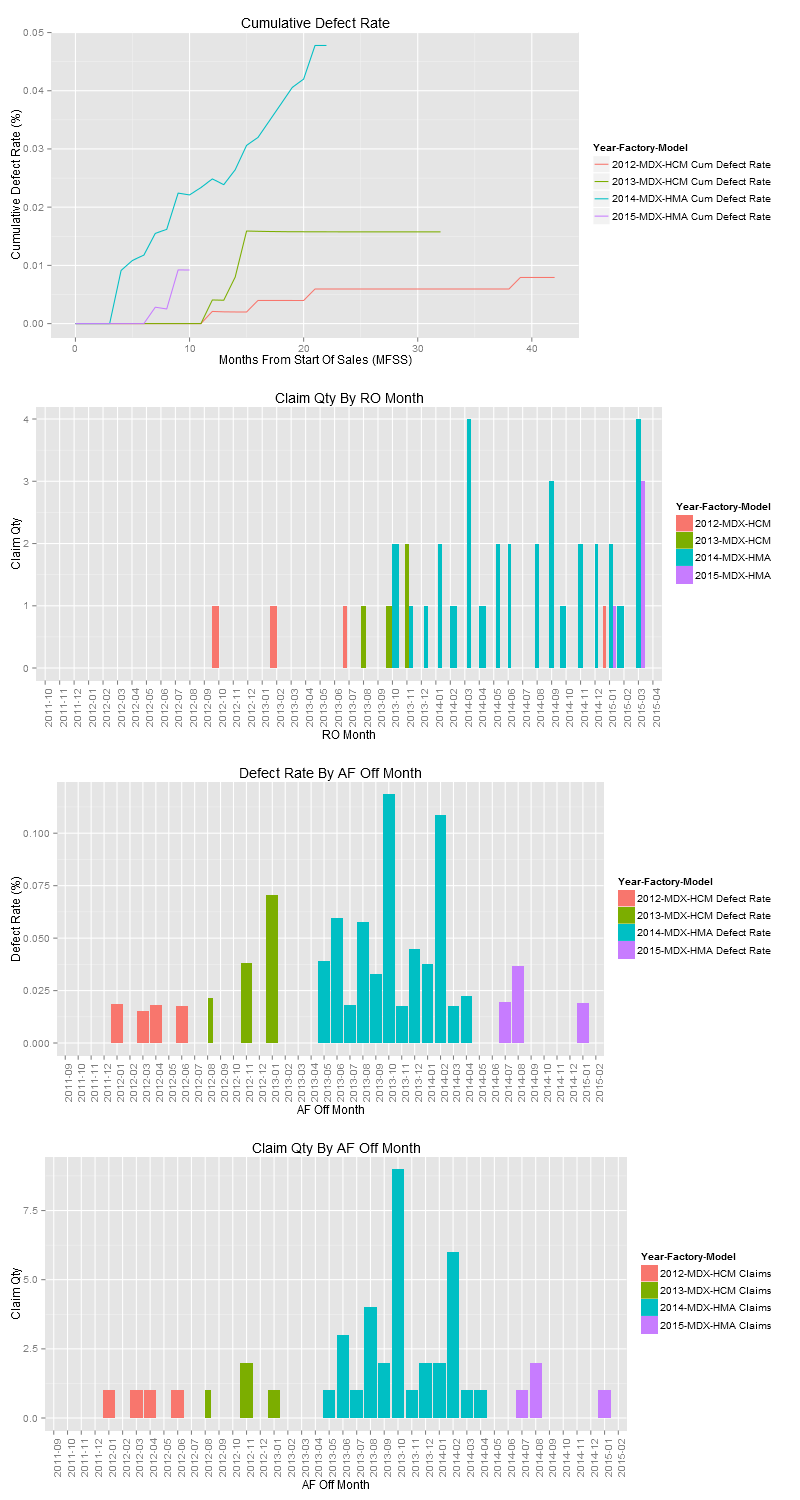

In [22]:
%%R -w 800 -h 1500 -u px # instead of px, you can also choose 'in', 'cm', or 'mm'
df <- as.data.frame(ro_df_long)
df <- as.data.frame(af_df_long)
df <- as.data.frame(af_claims)
df <- as.data.frame(ro_qty_long)

library(ggplot2)        # plotting library
library(gridExtra)      # to arrange charts in grid fashion

# Create cum defecte rate by MFSS chart
ro <- ggplot(ro_df_long, aes(ro_df_long$MFSS, ro_df_long$Def_Rate, color=ro_df_long$YR_MDL_FAC))
ro <- ro + 
    geom_line() +
    ggtitle("Cumulative Defect Rate") +
    xlab("Months From Start Of Sales (MFSS)") +
    ylab("Cumulative Defect Rate (%)") +
    scale_color_discrete(name = "Year-Factory-Model")

# Create claim qty by RO month
ro_qty <- ggplot(ro_qty_long, aes(ro_qty_long$RO_MTH, ro_qty_long$CLAIM_QTY, fill=ro_qty_long$YR_MDL_FAC))
ro_qty <- ro_qty +
    geom_bar(stat="identity", position="dodge") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    ggtitle("Claim Qty By RO Month") +
    xlab("RO Month") +
    ylab("Claim Qty") +
    scale_fill_discrete(name = "Year-Factory-Model")

# Create defect rate by AF off month
af <- ggplot(af_df_long, aes(af_df_long$AF_MTH, af_df_long$Def_Rate, fill=af_df_long$YR_MDL_FAC))
af <- af +
    geom_bar(stat="identity", position="dodge") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    ggtitle("Defect Rate By AF Off Month") +
    xlab("AF Off Month") +
    ylab("Defect Rate (%)") +
    scale_fill_discrete(name = "Year-Factory-Model")

# Create claim qty by AF off month
af_qty <- ggplot(af_claims, aes(af_claims$AF_MTH, af_claims$CLAIM_QTY, fill=af_claims$YR_MDL_FAC))
af_qty <- af_qty +
    geom_bar(stat="identity", position="dodge") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    ggtitle("Claim Qty By AF Off Month") +
    xlab("AF Off Month") +
    ylab("Claim Qty") +
    scale_fill_discrete(name = "Year-Factory-Model")

grid.arrange(ro, ro_qty, af, af_qty, ncol=1)

In [23]:
%R -i states_data

In [24]:
%%R -w 800 -h 600 -u px # Set dimension of R's output.  Instead of px, you can also choose 'in', 'cm', or 'mm'
df <- as.data.frame(states_data)
library(choroplethr)

choropleths = list()
for (i in 2:ncol(states_data)) {
  df           = states_data[, c(1, i)]
  colnames(df) = c("region", "value")
  #title        = paste0("Air Mix Motor Failures: ", colnames(states_data)[i])
  title        = paste0(colnames(states_data)[i])
  choropleths[[i-1]] = state_choropleth(df, title=title, legend="Defect Rate (%)", buckets=7)
}

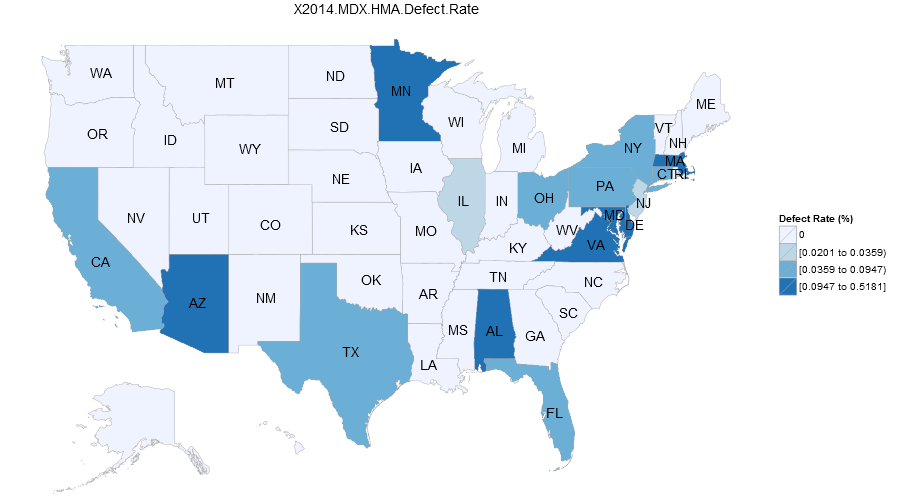

In [25]:
%%R -w 900 -h 500 -u px
choropleths[3]

In [44]:
import pandas as pd

excel_file = input("Enter full Excel file path: ")
excel_sheet_name = input("Enter Excel sheet name: ")

contention = pd.read_excel(excel_file, excel_sheet_name)

Enter full Excel file path: D:\temp\14M_MDX_Wiper_Arm_Warranty.xlsx
Enter Excel sheet name: contentions


In [45]:
%R -i contention

## WordCloud of the "CUSTOMER_CONTENTION_TEXT" column:

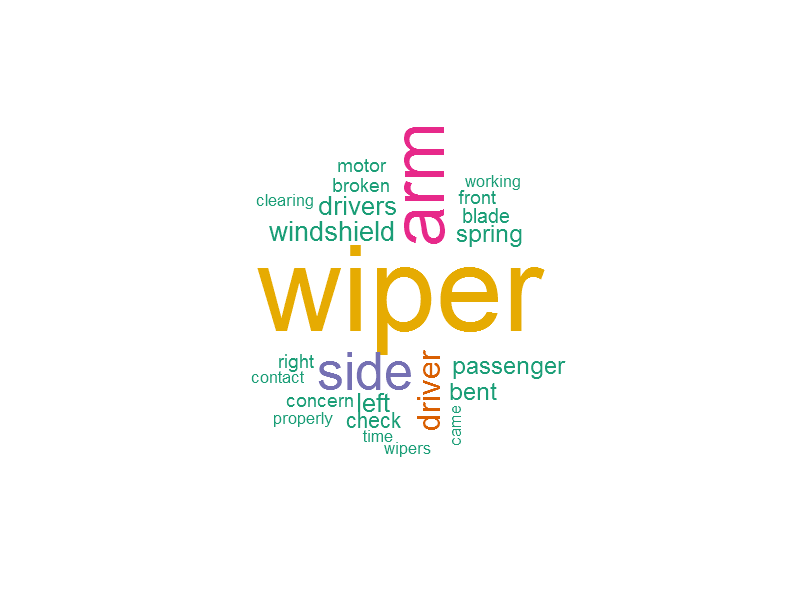

In [48]:
%%R -w 800 -h 600 -u px # instead of px, you can also choose 'in', 'cm', or 'mm'
df <- as.data.frame(contention)
library(tm)
library(wordcloud)
library(SnowballC)

doc.corpus <- Corpus(VectorSource(contention$CUSTOMER_CONTENTION_TEXT))
cleaned <- tm_map(doc.corpus,stripWhitespace)
cleaned <- tm_map(cleaned, content_transformer(tolower))
cleaned <- tm_map(cleaned,removeWords,stopwords("english"))
#cleaned <- tm_map(cleaned,stemDocument)
cleaned <- tm_map(cleaned,removeNumbers)
cleaned <- tm_map(cleaned,removePunctuation)

# Remove "worthless" words
cleaned <- tm_map(cleaned,removeWords, "customer")
cleaned <- tm_map(cleaned,removeWords, "cust")
cleaned <- tm_map(cleaned,removeWords, "client")
cleaned <- tm_map(cleaned,removeWords, "replace")
cleaned <- tm_map(cleaned,removeWords, "replaced")
cleaned <- tm_map(cleaned,removeWords, "repl")
cleaned <- tm_map(cleaned,removeWords, "states")
cleaned <- tm_map(cleaned,removeWords, "perform")
cleaned <- tm_map(cleaned,removeWords, "performed")
cleaned <- tm_map(cleaned,removeWords, "checked")
cleaned <- tm_map(cleaned,removeWords, "found")
cleaned <- tm_map(cleaned,removeWords, "advise")
cleaned <- tm_map(cleaned,removeWords, "inspect")
cleaned <- tm_map(cleaned,removeWords, "inspected")
cleaned <- tm_map(cleaned,removeWords, "tech")
cleaned <- tm_map(cleaned,removeWords, "technician")
cleaned <- tm_map(cleaned,removeWords, "new")
cleaned <- tm_map(cleaned,removeWords, "test")
cleaned <- tm_map(cleaned,removeWords, "please")

wordcloud(cleaned, min.words=1, colors=brewer.pal(6,"Dark2"),random.order=FALSE, scale=c(10,1))